In [1]:
pip install sbi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.0/460.0 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
 

In [2]:
import numpy as np
import torch

from sbi.inference import NPE
from sbi.utils import BoxUniform


# ----------------------------
# 0) User config
# ----------------------------
DATA_PATH = "lyalpha_train_z2.50_Nsims1000.npz"   # <-- change to your saved .npz
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Prior bounds must match how you generated theta:
T0_MIN, T0_MAX = 5000.0, 20000.0
GAMMA_MIN, GAMMA_MAX = 1.0, 2.0

# Pick a flow architecture (recommended by sbi docs is zuko_*; fallback to nflows-based nsf).
PREFERRED_DENSITY_ESTIMATOR = "zuko_nsf"  # recommended if zuko is available
FALLBACK_DENSITY_ESTIMATOR  = "nsf"       # works widely (via nflows/pyknos)


# ----------------------------
# 1) Load your precomputed simulations (theta, x)
# ----------------------------
data = np.load(DATA_PATH, allow_pickle=True)

X_np = data["X"].astype(np.float32)         # (N_sims, Npix) = (1000, 100)
theta_np = data["theta"].astype(np.float32) # (N_sims, 2)

# --- 80:20 train/test split (shuffled, reproducible) ---
SPLIT_SEED = 42
rng_split = np.random.default_rng(SPLIT_SEED)

N = X_np.shape[0]
idx = rng_split.permutation(N)

n_train = int(0.8 * N)
train_idx = idx[:n_train]
test_idx  = idx[n_train:]

X_train_np, theta_train_np = X_np[train_idx], theta_np[train_idx]
X_test_np,  theta_test_np  = X_np[test_idx],  theta_np[test_idx]

print("Train shapes:", X_train_np.shape, theta_train_np.shape)
print("Test  shapes:", X_test_np.shape,  theta_test_np.shape)

# Sanity checks on shapes
assert theta_np.ndim == 2 and theta_np.shape[1] == 2, f"theta shape is {theta_np.shape}, expected (N, 2)"
assert X_np.ndim == 2, f"X shape is {X_np.shape}, expected (N, Npix)"
assert X_np.shape[0] == theta_np.shape[0], "X and theta must have the same number of simulations"

N_sims, Npix = X_np.shape
print(f"Loaded: N_sims={N_sims}, Npix={Npix}")
print("theta range:",
      f"T0 in [{theta_np[:,0].min():.1f}, {theta_np[:,0].max():.1f}]",
      f"gamma in [{theta_np[:,1].min():.3f}, {theta_np[:,1].max():.3f}]")

# Convert to torch tensors (sbi expects float32 torch.Tensors)
x_train = torch.from_numpy(X_train_np).to(DEVICE)
theta_train = torch.from_numpy(theta_train_np).to(DEVICE)

x_test = torch.from_numpy(X_test_np).to(DEVICE)
theta_test = torch.from_numpy(theta_test_np).to(DEVICE)

Using device: cpu
Train shapes: (800, 100) (800, 2)
Test  shapes: (200, 100) (200, 2)
Loaded: N_sims=1000, Npix=100
theta range: T0 in [5007.0, 19964.6] gamma in [1.001, 2.000]


In [3]:
# ----------------------------
# 2) Define the prior p(theta)
# ----------------------------
low  = torch.tensor([T0_MIN, GAMMA_MIN], dtype=torch.float32, device=DEVICE)
high = torch.tensor([T0_MAX, GAMMA_MAX], dtype=torch.float32, device=DEVICE)
prior = BoxUniform(low=low, high=high)  # Uniform box prior over (T0, gamma)


# ----------------------------
# 3) Instantiate NPE + choose the density estimator (normalizing flow)
# ----------------------------
# Try the recommended zuko flow first; if not available in your environment, fall back.
try:
    inference = NPE(prior=prior, density_estimator=PREFERRED_DENSITY_ESTIMATOR, device=DEVICE)
    print(f"Using density_estimator='{PREFERRED_DENSITY_ESTIMATOR}' on device='{DEVICE}'")
except Exception as e:
    print(f"Could not use '{PREFERRED_DENSITY_ESTIMATOR}' (reason: {e})")
    inference = NPE(prior=prior, density_estimator=FALLBACK_DENSITY_ESTIMATOR, device=DEVICE)
    print(f"Falling back to density_estimator='{FALLBACK_DENSITY_ESTIMATOR}' on device='{DEVICE}'")

Using density_estimator='zuko_nsf' on device='cpu'


In [4]:
# ----------------------------
# 4) Append simulations and train the conditional density estimator q_phi(theta | x)
# ----------------------------
# This is the “learning” step: fit a conditional flow that maps (x -> distribution over theta).
density_estimator = inference.append_simulations(theta_train, x_train).train(
    training_batch_size=256,
    learning_rate=5e-4,
    validation_fraction=0.1,
    stop_after_epochs=20,
    max_num_epochs=10_000,
    clip_max_norm=5.0,
    show_train_summary=True,
)

# Build a DirectPosterior wrapper (rejects samples outside prior bounds, adds convenience methods).
posterior = inference.build_posterior()

 Neural network successfully converged after 62 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 62
        Best validation performance: 9.0595
        -------------------------
        


In [6]:
# ----------------------------
# A) Basic checks
# ----------------------------
print("x_test:", tuple(x_test.shape), "theta_test:", tuple(theta_test.shape))
assert x_test.ndim == 2 and x_test.shape[1] == 100
assert theta_test.ndim == 2 and theta_test.shape[1] == 2
assert x_test.shape[0] == theta_test.shape[0]

# Make sure we don't track gradients during evaluation
torch.set_grad_enabled(False)

# ----------------------------
# B) Log-prob on test set (batched)
# ----------------------------
# posterior.log_prob should return one log-prob per test sample.
# We'll do it in batches to be safe on Colab GPU/CPU memory.
BATCH = 256
logps = []

for start in range(0, x_test.shape[0], BATCH):
    end = min(start + BATCH, x_test.shape[0])

    xb = x_test[start:end]
    thetab = theta_test[start:end]

    # Depending on sbi version, calling convention can differ slightly.
    # This form works in current sbi versions for DirectPosterior:
    lp = posterior.log_prob_batched(thetab, x=xb)   # shape (batch,)
    logps.append(lp.detach().cpu())

logps = torch.cat(logps).numpy()  # shape (N_test,)

print("\nTest log_prob summary:")
print("  mean:", float(np.mean(logps)))
print("  std :", float(np.std(logps)))
print("  min :", float(np.min(logps)))
print("  max :", float(np.max(logps)))


x_test: (200, 100) theta_test: (200, 2)


AssertionError: Batch shape of condition 200 and input 1 do not match.

In [7]:
import numpy as np
import torch

# ----------------------------
# C) Sampling-based evaluation config
# ----------------------------
SAMPLES_PER_X = 2000   # posterior samples per test example
N_EVAL = min(200, x_test.shape[0])  # evaluate on first 200 test items (increase if you want)

# Credible interval levels to check (marginals)
CI_LEVELS = [0.50, 0.68, 0.90, 0.95]

# Storage
post_means = np.zeros((N_EVAL, 2), dtype=np.float32)
post_stds  = np.zeros((N_EVAL, 2), dtype=np.float32)

# coverage_counts[level, param_index]
coverage_counts = {lvl: np.zeros(2, dtype=np.int32) for lvl in CI_LEVELS}

# ----------------------------
# D) Loop over test observations and evaluate
# ----------------------------
for i in range(N_EVAL):
    x_i = x_test[i]        # shape (100,)
    theta_true = theta_test[i].detach().cpu().numpy()  # shape (2,)

    # Draw posterior samples: shape (SAMPLES_PER_X, 2)
    # (Direct sampling from the learned conditional flow.)
    samples = posterior.sample((SAMPLES_PER_X,), x=x_i)  # torch tensor
    samples_np = samples.detach().cpu().numpy()

    # Posterior mean/std as point summaries
    mu = samples_np.mean(axis=0)
    sd = samples_np.std(axis=0)

    post_means[i] = mu
    post_stds[i]  = sd

    # Credible interval coverage (marginal, per-parameter)
    for lvl in CI_LEVELS:
        alpha = 1.0 - lvl
        lo = np.quantile(samples_np, alpha/2, axis=0)
        hi = np.quantile(samples_np, 1 - alpha/2, axis=0)
        inside = (theta_true >= lo) & (theta_true <= hi)
        coverage_counts[lvl] += inside.astype(np.int32)

    if (i + 1) % 50 == 0 or (i + 1) == N_EVAL:
        print(f"[eval] {i+1}/{N_EVAL}")

# ----------------------------
# E) Compute summary metrics
# ----------------------------
theta_true_eval = theta_test[:N_EVAL].detach().cpu().numpy()

# RMSE for T0 and gamma using posterior mean as point estimate
rmse = np.sqrt(np.mean((post_means - theta_true_eval)**2, axis=0))
mae  = np.mean(np.abs(post_means - theta_true_eval), axis=0)

print("\nPoint-estimate error (posterior mean):")
print(f"  T0   RMSE: {rmse[0]:.2f}   MAE: {mae[0]:.2f}")
print(f"  gamma RMSE: {rmse[1]:.4f}   MAE: {mae[1]:.4f}")

print("\nMarginal credible-interval coverage (fraction of true values inside CI):")
for lvl in CI_LEVELS:
    cov = coverage_counts[lvl] / float(N_EVAL)
    print(f"  {int(lvl*100)}% CI coverage:  T0={cov[0]:.3f}, gamma={cov[1]:.3f}")


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

[eval] 50/200


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

[eval] 100/200


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

[eval] 150/200


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

[eval] 200/200

Point-estimate error (posterior mean):
  T0   RMSE: 2481.63   MAE: 2029.54
  gamma RMSE: 0.2650   MAE: 0.2206

Marginal credible-interval coverage (fraction of true values inside CI):
  50% CI coverage:  T0=0.455, gamma=0.485
  68% CI coverage:  T0=0.675, gamma=0.645
  90% CI coverage:  T0=0.890, gamma=0.840
  95% CI coverage:  T0=0.940, gamma=0.880


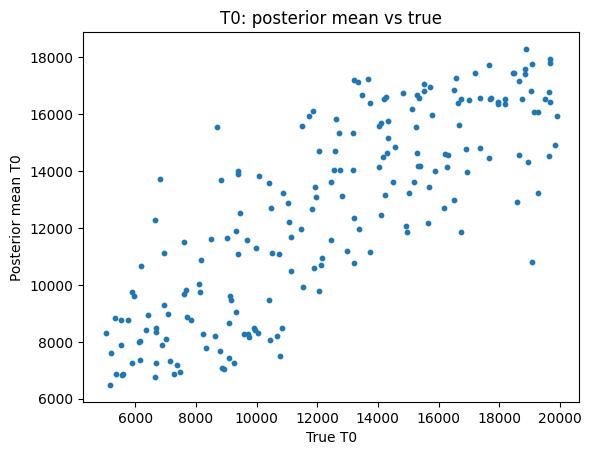

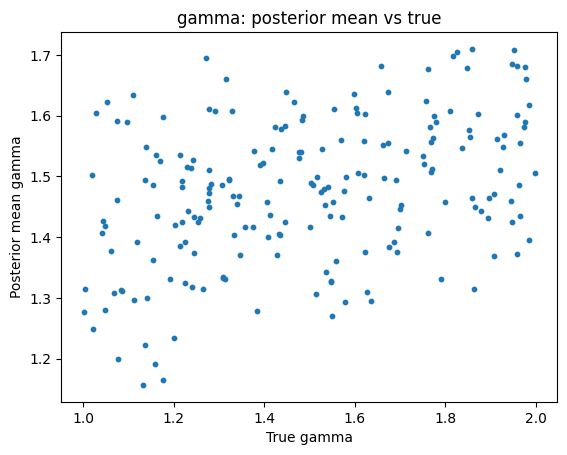

In [8]:
import matplotlib.pyplot as plt

theta_true_eval = theta_test[:N_EVAL].detach().cpu().numpy()

# T0: predicted vs true
plt.figure()
plt.scatter(theta_true_eval[:,0], post_means[:,0], s=10)
plt.xlabel("True T0")
plt.ylabel("Posterior mean T0")
plt.title("T0: posterior mean vs true")
plt.show()

# gamma: predicted vs true
plt.figure()
plt.scatter(theta_true_eval[:,1], post_means[:,1], s=10)
plt.xlabel("True gamma")
plt.ylabel("Posterior mean gamma")
plt.title("gamma: posterior mean vs true")
plt.show()


Random test index: 116
True params: T0=10410.5 K, gamma=1.137


  0%|          | 0/20000 [00:00<?, ?it/s]

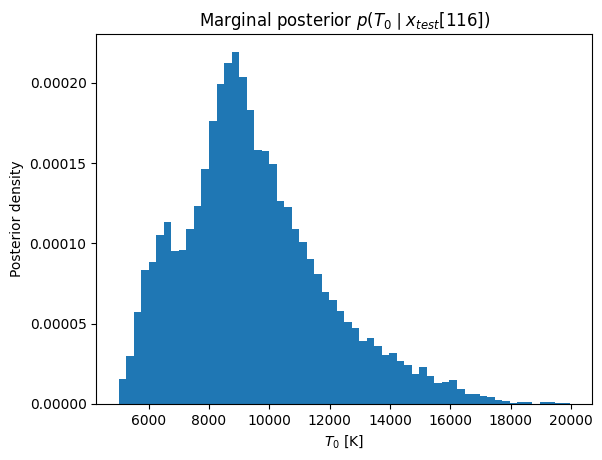

T0 median: 9162.1 K
68% CI  : [7153.7, 11810.8] K
95% CI  : [5749.1, 15255.9] K


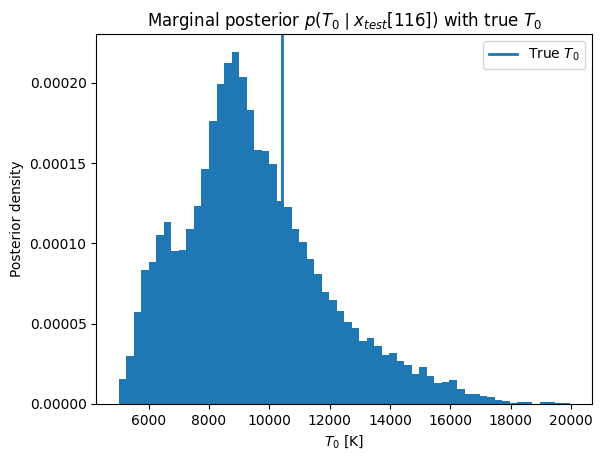

In [10]:
# Assumes you already have:
#   posterior  : sbi posterior object
#   x_test     : torch tensor, shape (N_test, Npix)  (on CPU or GPU)
#   theta_test : torch tensor, shape (N_test, 2)     (optional, for printing truth)

# ----------------------------
# 1) Pick a random test example
# ----------------------------
idx = torch.randint(low=0, high=x_test.shape[0], size=(1,)).item()

x_o = x_test[idx]  # shape (Npix,)
theta_true = theta_test[idx].detach().cpu().numpy()  # (2,)  [T0, gamma]

print(f"Random test index: {idx}")
print(f"True params: T0={theta_true[0]:.1f} K, gamma={theta_true[1]:.3f}")

# ----------------------------
# 2) Sample from p(theta | x_o)
# ----------------------------
S = 20000
samples = posterior.sample((S,), x=x_o)  # shape (S, 2)
samples_np = samples.detach().cpu().numpy()

T0_samps = samples_np[:, 0]

# ----------------------------
# 3) Plot marginal posterior p(T0 | x_o)
# ----------------------------
plt.figure()
plt.hist(T0_samps, bins=60, density=True)
plt.xlabel(r"$T_0$ [K]")
plt.ylabel("Posterior density")
plt.title(rf"Marginal posterior $p(T_0 \mid x_{{test}}[{idx}])$")
plt.show()

# ----------------------------
# 4) Credible intervals + overlay true T0
# ----------------------------
q16, q50, q84 = np.quantile(T0_samps, [0.16, 0.50, 0.84])
q025, q975 = np.quantile(T0_samps, [0.025, 0.975])

print(f"T0 median: {q50:.1f} K")
print(f"68% CI  : [{q16:.1f}, {q84:.1f}] K")
print(f"95% CI  : [{q025:.1f}, {q975:.1f}] K")

# Optional: show true T0 as a vertical line
plt.figure()
plt.hist(T0_samps, bins=60, density=True)
plt.axvline(theta_true[0], linewidth=2, label="True $T_0$")
plt.xlabel(r"$T_0$ [K]")
plt.ylabel("Posterior density")
plt.title(rf"Marginal posterior $p(T_0 \mid x_{{test}}[{idx}])$ with true $T_0$")
plt.legend()
plt.show()
